# DnnWeaver v2.0 tutorial
### The tutorial covers the basics of using DnnWeaver v2.0

## Part 1: Basics

In [1]:
import logging
import numpy as np
import array

from dnnweaver2.benchmarks import get_graph
from dnnweaver2.simulator.accelerator import Accelerator
from dnnweaver2.compiler import *
from dnnweaver2.fpga.fpgamanager import FPGAManager

from dnnweaver2.scalar.dtypes import FixedPoint

### Step 1: Express the DNN
DnnWeaver v2.0 expresses DNNs as a graph, 
where the nodes are the operations/layers like convolution and edges are tensors

The datatypes and bitwidths for the tensors are programmable
By default, DnnWeaver 2.0 uses 16-bit fixed-point datatypes for all tensors

The code snippe below expresses a single layers convolutional neural network

In [2]:
graph = Graph('YOLOv2-Test: 16-bit', dataset='imagenet', log_level=logging.INFO)
batch_size = 1

with graph.as_default():

    with graph.name_scope('inputs'):
        i = get_tensor(shape=(batch_size,32,32,3), name='data', dtype=FQDtype.FXP16, trainable=False)

    with graph.name_scope('conv0'):
        weights = get_tensor(shape=(128, 3, 3, 3),
                             name='weights',
                             dtype=FixedPoint(16,12))
        biases = get_tensor(shape=(128),
                             name='biases',
                             dtype=FixedPoint(32,20))
        conv = conv2D(i, weights, biases, pad='SAME', dtype=FixedPoint(16,8))
    # DnnWeaver2 automatically takes care of type conversion
    with graph.name_scope('pool1'):
        pool = maxPool(conv, pooling_kernel=(1,2,2,1), stride=(1,2,2,1), pad='VALID')


print('*'*50)
print('List of ops (nodes) in the graph')
# print the ops in the yolo2_graph
for op in graph.op_registry:
    print('\tOp name: {}'.format(op))
print('*'*50)
    
print('*'*50)
print('List of tensors (edges) in the graph')
# print the tensors in the yolo2_graph
for tname, t in graph.tensor_registry.iteritems():
    print('\t{}'.format(t))
print('*'*50)

**************************************************
List of ops (nodes) in the graph
	Op name: conv0/Convolution
	Op name: conv0/TypeCastOp
	Op name: pool1/MaxPooling
**************************************************
**************************************************
List of tensors (edges) in the graph
	inputs/data[1,32,32,3] (FXP16 (8,8))
	conv0/weights[128,3,3,3] (FXP16 (4,12))
	conv0/biases[128] (FXP32 (12,20))
	conv0/Convolution[1,32,32,128] (FXP64 (44,20))
	conv0/TypeCastOp[1,32,32,128] (FXP16 (8,8))
	pool1/MaxPooling[1,16,16,128] (FXP16 (8,8))
**************************************************


### Step 2: Compile the graph to generate instructions for the FPGA accelerator
1. Define the accelerator object
2. Optimize tiling for the accelerator and generate instruction binary for the accelerator

In [3]:
# Step 2.1
# on-chip BRAM buffers (number_bram * data_type * entries)
num_rows = 32
num_cols = 32
bram = {
    'ibuf':            num_cols * 16 * 2048 / 2,
    'obuf':            num_rows * 64 * 2048 / 2,
    'wbuf': num_cols * num_rows * 16 *  512 / 2,
    'bbuf':            num_rows * 32 * 2048 / 2,
}
acc_obj = Accelerator(
    N=num_rows, M=num_cols,
    prec=16,
    mem_if_width=256,
    frequency=150e6,
    sram=bram
)

print(acc_obj.__str__())

Accelerator object
	Precision: 16
	Systolic array size: 32 -rows x 32 -columns
	IBUF size:     65,536 Bytes
	WBUF size:    524,288 Bytes
	OBUF size:    262,144 Bytes
	BBUF size:    131,072 Bytes
Double buffering enabled. Sizes of SRAM are halved


In [4]:
# Step 2.2
log_level = logging.INFO
compiler = GraphCompiler(log_level=log_level)
inst_binary = compiler.compile(graph=graph, acc_obj=acc_obj)

print('Number of instructions: {}'.format(inst_binary.size))

Number of instructions: 124


### Step 3: Run the compile DNN graph on the FPGA
DnnWeaver v2.0 provides a FPGAManager class to use the FPGA

In [5]:
# Program the accelerator
fpga_manager = FPGAManager()
fpga_manager.write('pci_cl_data', 0, inst_binary)

import time

num_tests = 100
start = time.time()
for i in range(num_tests):    
    # Start the accelerator
    fpga_manager.start()
    # Wait for execution to finish
    fpga_manager.wait_fpga_execution()
end = time.time()

print('Frames per second: {}'.format(1./(end-start)))

Frames per second: 18.9846784743


## Part 2: The second part of the tutorial uses DnnWeaver to run YOLO for object recognition

In [6]:
from example.dnn_fpga import *
from example.yolo_demo import *
from darkflow.net.build import TFNet

import cv2
import copy
from IPython.display import Image

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

### First, we will create a tensorflow graph using the darkflow library

In [7]:
options = {"model": "example/conf/tiny-yolo-voc.cfg", "load": "example/weights/tiny-yolo-voc.weights", "threshold": 0.25}
tfnet = TFNet(options)

/home/hardik/projects/darkflow/darkflow/dark/darknet.py:54: UserWarning: ./cfg/tiny-yolo-voc.cfg not found, use example/conf/tiny-yolo-voc.cfg instead
  cfg_path, FLAGS.model))


Parsing example/conf/tiny-yolo-voc.cfg
Loading example/weights/tiny-yolo-voc.weights ...
Successfully identified 63471556 bytes
Finished in 0.00347089767456s
Model has a VOC model name, loading VOC labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Load  | 

### Next, we will read in an image (png/jpeg) and run inference using both tensorflow (CPU) and DnnWeaver v2.0 (FPGA)

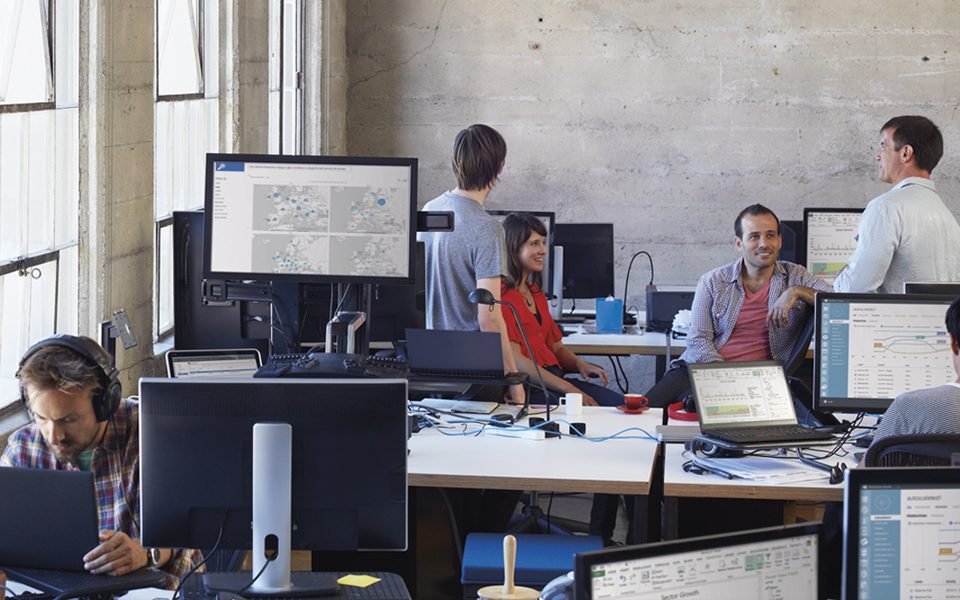

In [8]:
input_png = 'example/test.jpg'
input_im = cv2.imread(input_png, cv2.IMREAD_COLOR)
h, w, _ = input_im.shape
im = tfnet.framework.resize_input(input_im)
tin = np.expand_dims(im, 0)
Image(filename='example/test.jpg')

# Finally, we will read the weights for both tensorflow and DnnWeaver v2.0 and run inference on both
We will compare the results from tensorflow and DnnWeaver v2.0

INFO:FPGA Manager:Systolic array: 32x32
INFO:FPGA Manager:Initializing graph: YOLOv2-Test: 16-bit
INFO:FPGA Manager:clearing data in DDR
INFO:FPGA Manager:clearing data in DDR - done!


conv8
layer ~conv8: nrmse = 0.13501809%	FPS: 12.1	Inference time: 0.08 sec


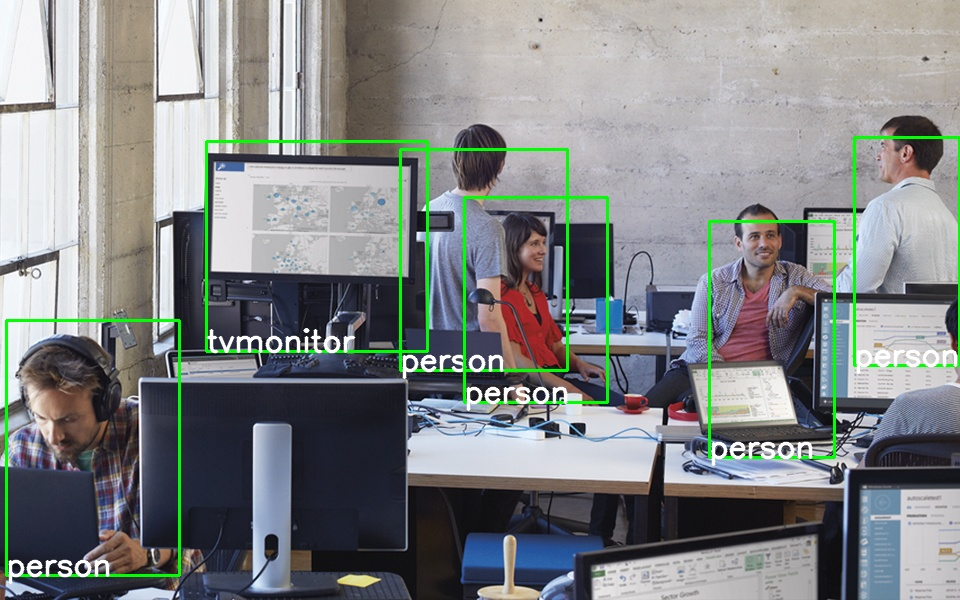

In [9]:
weight_pickle = 'example/weights/yolo2_tiny_tf_weights.pickle'
my_tin = copy.deepcopy(tin)
fpga_tin = copy.deepcopy(tin)
my_touts = run_tf(my_tin, weight_pickle)

dw_weight_pickle = 'example/weights/yolo2_tiny_dnnweaver2_weights.pickle'
fpga_touts, fxp_fpga_touts = run_fpga(fpga_tin, dw_weight_pickle)

for key in fpga_touts.keys():
    print(key)
    my_o = my_touts[key]
    fpga_o, fpga_fps, fpga_inference_time = fpga_touts[key]
    print "layer ~" + str(key) + ": nrmse = %.8f%%\tFPS: %.1f\tInference time: %.2f sec" % (((np.sqrt(np.mean((my_o - fpga_o) ** 2))) / (my_o.max() - my_o.min()) * 100) ,fpga_fps,fpga_inference_time)

result = get_bbox(tfnet, fpga_touts["conv8"][0][0], h, w)

font = cv2.FONT_HERSHEY_SIMPLEX
for det in result:
    label, l, r, t, b = det['label'], det['topleft']['x'], det['bottomright']['x'], det['topleft']['y'], det['bottomright']['y']
    cv2.rectangle(input_im, (l, b), (r, t), (0, 255, 0), 2)
    cv2.putText(input_im, label, (l, b), font, 1, (255, 255, 255), 2, cv2.CV_AA)

output_filename = os.path.join(os.path.dirname(input_png), "bbox-" + os.path.basename(input_png))
cv2.imwrite(output_filename, input_im)
Image(filename=output_filename)